In [1]:
import pandas as pd

# Load the dataset directly from GitHub

books_url = 'https://raw.githubusercontent.com/a-lindsay21/Book-Genre-Classifier/refs/heads/main/data/Books.csv'
ratings_url = 'https://raw.githubusercontent.com/a-lindsay21/Book-Genre-Classifier/refs/heads/main/data/Ratings.csv'
to_read_url = 'https://raw.githubusercontent.com/a-lindsay21/Book-Genre-Classifier/refs/heads/main/data/to_read.csv'

books = pd.read_csv(books_url)
ratings = pd.read_csv(ratings_url)
to_read = pd.read_csv(to_read_url)

In [2]:
# Explore the Books dataset
print("Books Dataset:")
print(books.head())
print(books.info())

# Explore the Ratings dataset
print("\nRatings Dataset:")
print(ratings.head())
print(ratings.info())

# Explore the To-Read dataset
print("\nTo-Read Dataset:")
print(to_read.head())
print(to_read.info())


Books Dataset:
   Unnamed: 0        ISBN  book_id  Publication Year  \
0           0  0195153448        1              2008   
1           1  0002005018        2              1997   
2           2  0060973129        3              2005   
3           3  0374157065        4              1960   
4           4  0393045218        5              1925   

                        Author  \
0              Suzanne Collins   
1  J.K. Rowling, Mary GrandPré   
2              Stephenie Meyer   
3                   Harper Lee   
4          F. Scott Fitzgerald   

                                               Title  AvgRating  \
0            The Hunger Games (The Hunger Games, #1)       4.34   
1  Harry Potter and the Sorcerer's Stone (Harry P...       4.44   
2                            Twilight (Twilight, #1)       3.57   
3                              To Kill a Mockingbird       4.25   
4                                   The Great Gatsby       3.89   

                                        

In [3]:
# Drop unnecessary columns from Books
books_cleaned = books.drop(columns=['Unnamed: 0', 'Image-URL', 'Image-URL-S'])

# Merge Books and Ratings on 'book_id'
merged_data = ratings.merge(books_cleaned, on='book_id', how='inner')

# Compute additional features
book_stats = merged_data.groupby('book_id').agg({
    'rating': ['count', 'mean'],  # Total and average rating
    'Publication Year': 'max',    # Latest publication year
}).reset_index()

# Rename columns
book_stats.columns = ['book_id', 'Total Ratings', 'Avg Rating', 'Publication Year']

print(book_stats.head())


   book_id  Total Ratings  Avg Rating  Publication Year
0        1            100        4.24              2008
1        2            100        4.21              1997
2        3            100        3.09              2005
3        4            100        4.46              1960
4        5            100        3.89              1925


In [4]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = book_stats[['Total Ratings', 'Avg Rating', 'Publication Year']]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


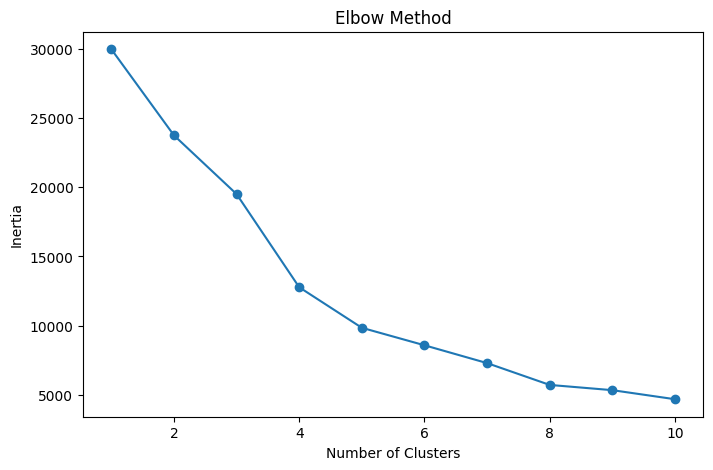

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [6]:
# Choose the optimal number of clusters from the elbow plot
optimal_clusters = 4  # Replace with the number you choose
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
book_stats['Cluster'] = kmeans.fit_predict(features_scaled)

print(book_stats.head())


   book_id  Total Ratings  Avg Rating  Publication Year  Cluster
0        1            100        4.24              2008        0
1        2            100        4.21              1997        0
2        3            100        3.09              2005        1
3        4            100        4.46              1960        0
4        5            100        3.89              1925        0


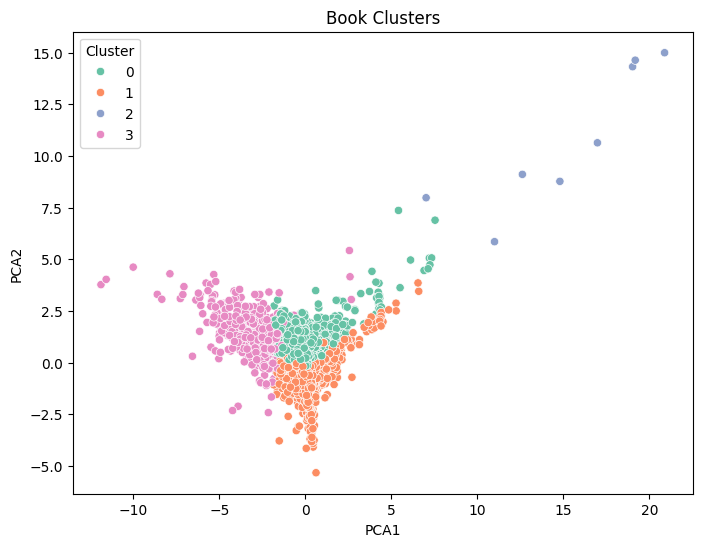

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)
book_stats['PCA1'] = pca_features[:, 0]
book_stats['PCA2'] = pca_features[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=book_stats, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Book Clusters')
plt.show()


In [8]:
cluster_profiles = book_stats.groupby('Cluster')[['Total Ratings', 'Avg Rating', 'Publication Year']].mean()
print(cluster_profiles)


         Total Ratings  Avg Rating  Publication Year
Cluster                                             
0            99.174954    4.061716       1988.099632
1            99.209100    3.582855       1993.449903
2            97.375000    3.750082        526.000000
3            75.639535    3.909915       1995.518605


In [12]:
# Cluster Analysis
cluster_profiles = book_stats.groupby('Cluster').mean()

# Cluster Interpretation
print("Cluster 0:")
print("Older books (~1988) with relatively high average ratings (~4.06) and high total ratings.")

print("\nCluster 1:")
print("Newer books (~1993) with lower average ratings (~3.58) but similar total ratings as Cluster 0.")

print("\nCluster 2:")
print("Possibly mislabeled books (~year 526), moderate average ratings (~3.75), and fewer total ratings.")

print("\nCluster 3:")
print("Books from ~1995, moderate ratings (~3.91), but significantly fewer total ratings compared to other clusters.")


Cluster 0:
Older books (~1988) with relatively high average ratings (~4.06) and high total ratings.

Cluster 1:
Newer books (~1993) with lower average ratings (~3.58) but similar total ratings as Cluster 0.

Cluster 2:
Possibly mislabeled books (~year 526), moderate average ratings (~3.75), and fewer total ratings.

Cluster 3:
Books from ~1995, moderate ratings (~3.91), but significantly fewer total ratings compared to other clusters.


<ipython-input-13-446ebdc49998>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Total Ratings', data=book_stats, palette='pastel')


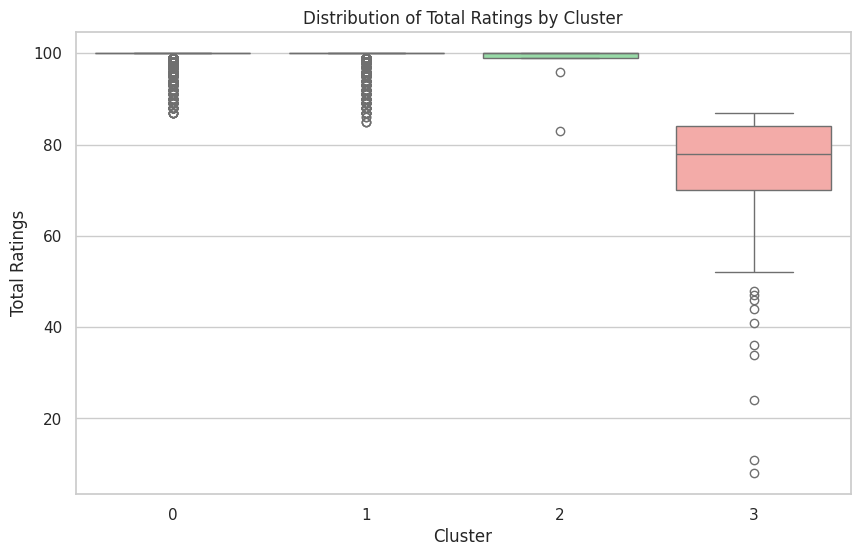

<ipython-input-13-446ebdc49998>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Avg Rating', data=book_stats, palette='muted')


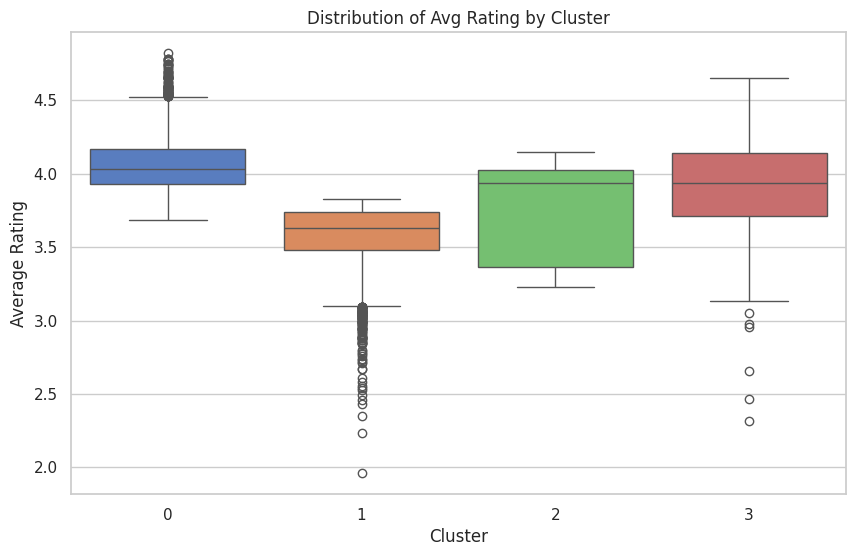

<ipython-input-13-446ebdc49998>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Publication Year', data=book_stats, palette='Set2')


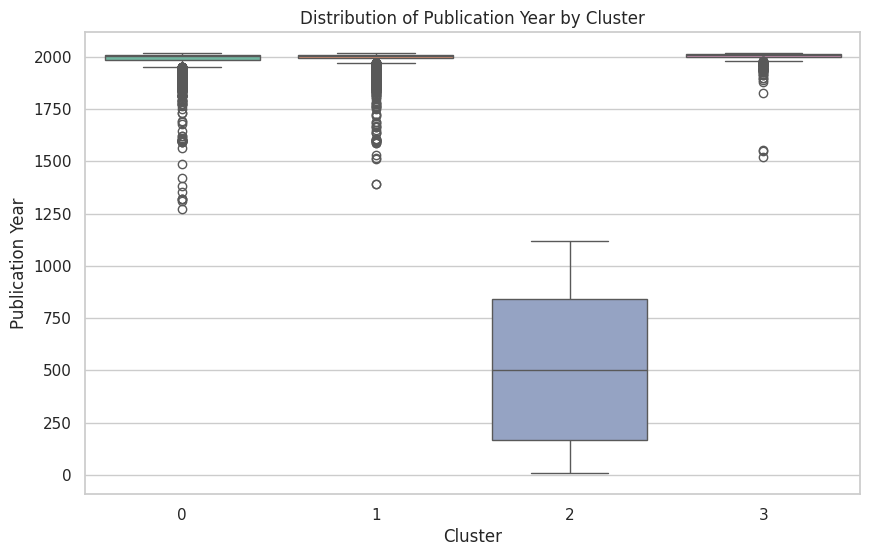

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better visuals
sns.set(style="whitegrid")

# Create a figure for Total Ratings by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Total Ratings', data=book_stats, palette='pastel')
plt.title('Distribution of Total Ratings by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Ratings')
plt.show()

# Create a figure for Avg Rating by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Avg Rating', data=book_stats, palette='muted')
plt.title('Distribution of Avg Rating by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Rating')
plt.show()

# Create a figure for Publication Year by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Publication Year', data=book_stats, palette='Set2')
plt.title('Distribution of Publication Year by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Publication Year')
plt.show()


In [14]:
# Save the clustered dataset
book_stats.to_csv('clustered_books.csv', index=False)
print("File 'clustered_books.csv' has been created!")


File 'clustered_books.csv' has been created!


In [15]:
from google.colab import files
files.download('clustered_books.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>